In [1]:
!pip install tensorflow-datasets

/bin/bash: /home/cmatheus/anaconda3/envs/tf-gans/lib/libtinfo.so.6: no version information available (required by /bin/bash)

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


* Vamos trabalhar com MNIST(Modified National Institute of Standards and Technology) da base de datasets do tensorflow
* entender como RBM(Restricted Boltzmann Machine)- a simple neural network - é treinado para minimizar a "energia " equação que se assemelha a fórmulas de física para gerar imagens.
* como empilhar varios RBMs para fazer uma DBN e aplicar forward e backward avançando para o pre treinamento da rede para gerar imagem
* Como implementar classificardor fim-a-fim combinando o pre-treinado com backpropagation "fine-tuning" usando tf2 api

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [7]:
# Aqui vamos realizar o download dos dados diretamento do GCS ( GOOGLE CLOUD STORE)
mnist_builder = tfds.builder("mnist")
#mnist_builder.download_and_prepare()


verificando o dataset

In [8]:
info = mnist_builder.info
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/home/cmatheus/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


podemos ver que o dataset de treino é composto por 60k de imagens de tamanho 28x28 e  o teste possui 10k com o mesmo tamanho.

olhando o dataset de treino

In [9]:
mnist_train = mnist_builder.as_dataset(split="train")

2023-03-05 02:28:56.137426: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


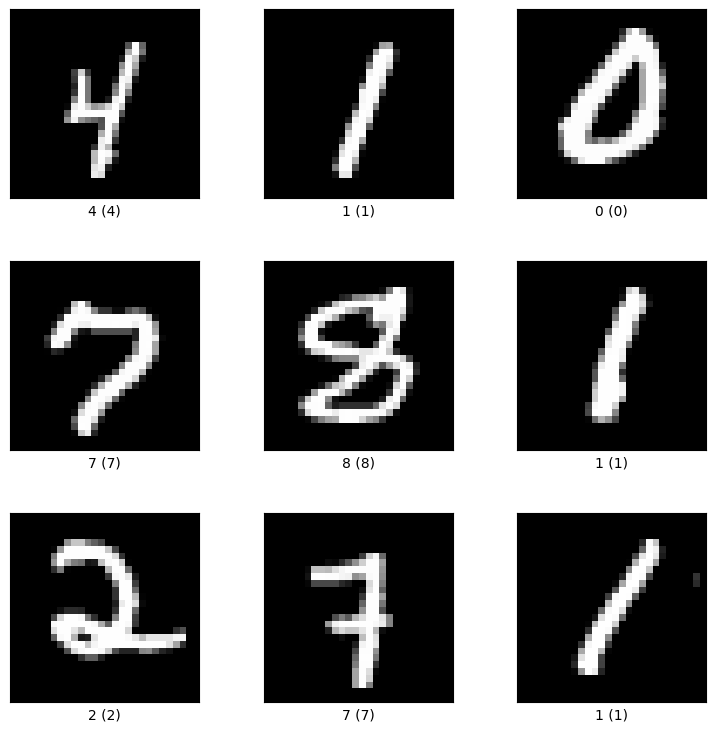

In [10]:
fig = tfds.show_examples(mnist_train,info)

Label: 4


2023-03-05 02:28:57.322477: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-05 02:28:57.322766: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


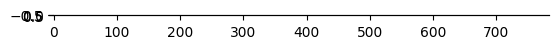

In [11]:
def flatten_img(x,label=True):
    if label:
        return (tf.divide(tf.dtypes.cast(tf.reshape(x["image"],(1,28*28)),tf.float32),256.0),x["label"])
    else:
        return (tf.divide(tf.dtypes.cast(tf.reshape(x["image"],(1,28*28)),tf.float32),256.0))
    
for image, label in mnist_train.map(flatten_img).cache().take(1):
    plt.imshow(image.numpy().astype(np.float32), cmap=plt.get_cmap("gray"))
    print("Label: %d" % label.numpy())

2023-03-05 02:28:57.659061: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-05 02:28:57.659431: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Label: 4


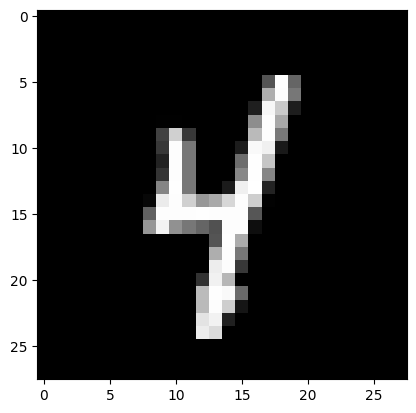

In [12]:
from functools import partial


flatten_image = partial(flatten_img, label=True)

for image, label in mnist_train.map(flatten_image).cache().take(1):
    plt.imshow(image.numpy().reshape(28,28).astype(np.float32),cmap=plt.get_cmap("gray"))
    print("Label: %d" % label.numpy())

In [1]:
import tensorflow as tf

2023-03-05 03:18:48.471319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 03:18:49.861619: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/cmatheus/anaconda3/envs/tf-gans/lib/
2023-03-05 03:18:49.867483: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/cmatheus/anaconda3/envs/tf-gans/lib/
2023-03-05 03:18:49.867508: W tensorflow/compil

In [1]:
from rbm import RBM

2023-03-05 03:21:54.158126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 03:21:55.596021: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/cmatheus/anaconda3/envs/tf-gans/lib/
2023-03-05 03:21:55.600220: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/cmatheus/anaconda3/envs/tf-gans/lib/
2023-03-05 03:21:55.600241: W tensorflow/compil

In [2]:
input_shape=[784]
input_shape

[784]

In [3]:
#tensor_variavel = tf.Variable([0,784], shape=(2,))

In [4]:
["a",8]

['a', 8]

In [5]:
rbm_net = RBM([500])
#input_shape = tensor_variavel.numpy()
#tensor = tf.random.normal(shape)

rbm_net.build(input_shape=[784])
epochs = 100



entrou no if
valor 784
hidden:(500,)


2023-03-05 03:22:01.982854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-05 03:22:02.036171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-05 03:22:02.036886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-05 03:22:02.040077: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

784
passou vb
visible:784
hidden:(500,)


e
Your kernel may have been built without NUMA support.
2023-03-05 03:22:02.042635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-05 03:22:02.043169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-05 03:22:05.122331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-05 03:22:05.122892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA s

In [7]:
def train_rbm(rbm=None,data=mnist_train,map_fn=flatten_image, num_epochs=100,
              tolerance=1e-3,batch_size=32,shuffle_buffer=1024):
    last_cost= None

    for epoch in range(num_epochs):
        cost=0.0
        count=0.0
        for datapoints in data.map(map_fn).shuffle(shuffle_buffer).batch(batch_size):
            cost+=rbm.cd_update(datapoints)
            count+=1
            print("epoch: {}, cost: {}".format(epoch, cost))
            if last_cost and abs(last_cost-cost)<= tolerance:
                break
            last_cost = cost
        
        return rbm

NameError: name 'mnist_train' is not defined

In [21]:
rbm = train_rbm(rbm_net, mnist_train, partial(flatten_image, label=False),
100, 0.5, 2000)

2023-03-04 23:35:52.992057: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


AttributeError: 'RBM' object has no attribute 'hb'